In [1]:
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 

In [2]:
df=pd.read_csv('dataset_spams.csv', sep=',')

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [5]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [6]:
1368/4360

0.3137614678899083

In [7]:
# Creating category spam=1 and non spam=0
df_spam=df[df['spam']==1]
df_spam.shape

(1368, 2)

In [8]:
df_ham=df[df['spam']==0]
df_ham.shape

(4360, 2)

In [9]:
df_ham.sample(5)

,text,spam
1979,Subject: re : mid - project review dates - enr...,0
3142,Subject: super saturday changes - update i am...,0
2569,Subject: fwd : billing question return - path...,0
1711,Subject: organization announcement given the ...,0
2305,Subject: don ' t forget - coffee colloquium th...,0


In [10]:
df_spam.sample(5)

,text,spam
1055,"Subject: yourr medz hello , welcome to ph dis...",1
919,Subject: jump start desire in both men and wom...,1
77,Subject: you only think you ' re u . s . citiz...,1
503,Subject: any med for your girl to be happy ! ...,1
1350,Subject: re : wall street micro news report h...,1


In [11]:
# Downsampling 
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1368, 2)

In [12]:
df_balanced=pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(2736, 2)

In [13]:
df_balanced['spam'].value_counts()

0    1368
1    1368
Name: spam, dtype: int64

In [14]:
df_balanced.sample(5)

,text,spam
4366,Subject: request submitted : access request fo...,0
1399,Subject: re : fw : parent - subsidary model h...,0
495,Subject: home loans just got better ! free se...,1
2724,"Subject: modeling in real options vince , my...",0
204,Subject: get a costco gold membership . this ...,1


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df_balanced['text'], df_balanced['spam'], stratify=df_balanced['spam'])

In [16]:
X_train.shape, X_test.shape

((2052,), (684,))

In [17]:
X_train.head()

1311    Subject: localized software , all languages av...
5432    Subject: re : 2001 preliminary i / c billing  ...
1218    Subject: a quick , cheap and convenient way to...
30      Subject: want to accept credit cards ? 1264322...
309     Subject: viagra is the # 1 med to struggle wit...
Name: text, dtype: object

In [18]:
bert_preprocess=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [19]:
# Function that call ber_process and encoder 
def get_sentence_embeding(sentences):
    preprocessed_text=bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


get_sentence_embeding([
    "500$ discount, hurry up", 
    "Bhavin, are you up for volleybal game tomorrow"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7734201 , -0.501377  , -0.8073745 , ..., -0.60576564,
        -0.7409629 ,  0.8849831 ],
       [-0.8912391 , -0.57984865, -0.96718585, ..., -0.8741101 ,
        -0.7362526 ,  0.8688713 ]], dtype=float32)>

In [20]:
e =get_sentence_embeding([
    'banana',
    'grapes', 
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [21]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069176, -0.14219394,  0.4960459 , ...,  0.42165306,
        -0.5322142 ,  0.8031218 ],
       [-0.86023223, -0.21242936,  0.4915693 , ...,  0.3979806 ,
        -0.6050628 ,  0.84471637],
       [-0.712886  , -0.15463904,  0.3840168 , ...,  0.3527874 ,
        -0.5099133 ,  0.73474073],
       [-0.82533467, -0.35550585, -0.590697  , ..., -0.01613702,
        -0.6141757 ,  0.87230295],
       [-0.75041336, -0.26812622, -0.26689756, ...,  0.02839338,
        -0.5938099 ,  0.7974989 ],
       [-0.7854437 , -0.2994969 ,  0.41027388, ...,  0.5222541 ,
        -0.4957355 ,  0.815075  ]], dtype=float32)>

In [22]:
# Looking Similarities 
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[4]] )

array([[0.893363]], dtype=float32)

In [23]:
# Bert layers
text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_tex=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_tex)

# Neural network layers
l=tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# contruct final model
model=tf.keras.Model(inputs=[text_input], outputs=[l])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [25]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=METRICS)

In [26]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
65/65 [==============================] - 248s 4s/step - loss: 0.6461 - accuracy: 0.6326 - precision: 0.6365 - recall: 0.6179
Epoch 2/15
65/65 [==============================] - 244s 4s/step - loss: 0.5731 - accuracy: 0.7173 - precision: 0.7226 - recall: 0.7057
Epoch 3/15
65/65 [==============================] - 241s 4s/step - loss: 0.5184 - accuracy: 0.7797 - precision: 0.7836 - recall: 0.7729
Epoch 4/15
65/65 [==============================] - 239s 4s/step - loss: 0.4832 - accuracy: 0.7992 - precision: 0.8046 - recall: 0.7904
Epoch 5/15
65/65 [==============================] - 239s 4s/step - loss: 0.4651 - accuracy: 0.8036 - precision: 0.7992 - recall: 0.8109
Epoch 6/15
65/65 [==============================] - 239s 4s/step - loss: 0.4381 - accuracy: 0.8241 - precision: 0.8206 - recall: 0.8294
Epoch 7/15
65/65 [==============================] - 240s 4s/step - loss: 0.4150 - accuracy: 0.8397 - precision: 0.8400 - recall: 0.8392
Epoch 8/15
65/65 [==============================

In [27]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 80s 4s/step - loss: 0.3267 - accuracy: 0.8962 - precision: 0.8928 - recall: 0.9006


[0.32671812176704407,
 0.8961988091468811,
 0.8927536010742188,
 0.9005848169326782]

In [28]:
# Prediction 
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()

22/22 [==============================] - 81s 4s/step


In [29]:
import numpy as np
y_predicted=np.where(y_predicted>0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test, y_predicted)
cm

array([[305,  37],
       [ 34, 308]], dtype=int64)

Text(33.0, 0.5, 'Truth')

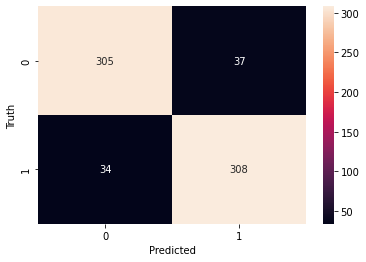

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       342
           1       0.89      0.90      0.90       342

    accuracy                           0.90       684
   macro avg       0.90      0.90      0.90       684
weighted avg       0.90      0.90      0.90       684



###### Inference

In [33]:
reviews=[
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021', 
    'You are awarded a SiPix Digital Camera!, call 090601222125 from landline. Delivery within 28 days. T cs Box1777. M221BP',
    'it to 80488. Your free text messages are valid until 31 December 2005', 
    'Hey Sam, Are you coming for a cricket game tomorrow', 
    "Why don't you wait 'til at least wednesday to see if you get your."
    ]

model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.8503735 ],
       [0.8677433 ],
       [0.71123683],
       [0.6562119 ],
       [0.8943253 ]], dtype=float32)